In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

### global configuration

In [2]:
NN = 14 # node num
G_type = 'ba' # type of graph: ws / ba
SN = 128 # resample num
T = 3999 # step in each sample
Noise_Level = 0.1 # in each step, any node has a probability to choose a state randomly rather than following the dynamics rule
Dyn_Type = 'voter' #options: voter / minority_game / majority_vote / kirman


seed = 2050
np.random.seed(seed)
random.seed(seed)

### func : generate the network structure

In [3]:
def generate_network(NN):
    if G_type == 'ba':
        BA = nx.random_graphs.barabasi_albert_graph(NN, 1)
        return BA
    elif G_type == 'ws':
        WS = nx.random_graphs.watts_strogatz_graph(NN, 4, 0.3)
    return WS

## get innodes of nodes

In [4]:
# get the innode of each node 
# return:{0:[1,2,3],1:[0,4]...}
def get_innodes(adj):
    innodes = {}
    for i in range(adj.shape[0]):
        innode = []
        for j in range(adj.shape[0]):
            if adj[j][i] == 1:
                innode.append(j)
        innodes[i] = innode
    return innodes

## differnt dynamics of spreading

In [5]:
def voter_dyn(dg):
    node_num = dg.number_of_nodes()
    next_val = []
    for i in range(node_num):
        # num for neighbors who vote for agree
        k = 0.
        # num for all neighbors
        m = len(innodes[i])
        for idx,val in enumerate(innodes[i]):
            if dg.nodes[val]['value'] == 1:
                k += 1.
        if random.random() < k / m:
            next_val.append(1)
        else:
            next_val.append(0)
    return next_val

In [6]:
def minority_game_dyn(dg):
    node_num = dg.number_of_nodes()
    next_val = []
    # current value
    curr_val = []
    for i in range(node_num):
        curr_val.append(dg.nodes[i]['value'])
    for i in range(node_num):
        # num for neighbors who's state is 1
        one_num = 0.
        # num for all neighbors
        m = float(len(innodes[i]))
        for idx,val in enumerate(innodes[i]):
            if dg.nodes[val]['value'] == 1:
                one_num += 1.
        p01 = (m-one_num) / m
        p10 = one_num / m
        # if current value is 0 then we will look at p01
        if curr_val[i] == 0:
            if random.random() < p01:
                next_val.append(1)
            else:
                next_val.append(0)
        else:
            if random.random() < p10:
                next_val.append(0)
            else:
                next_val.append(1)
    return next_val

In [7]:
def majority_vote_dyn(dg):
    Q = 0.3
    node_num = dg.number_of_nodes()
    next_val = []
    # current value
    curr_val = []
    for i in range(node_num):
        curr_val.append(dg.nodes[i]['value'])
    for i in range(node_num):
        # num for neighbors who's state is 1
        one_num = 0.
        # num for all neighbors
        m = float(len(innodes[i]))
        for idx,val in enumerate(innodes[i]):
            if dg.nodes[val]['value'] == 1:
                one_num += 1.
        gate = one_num / m
        if gate == 0.5:
            next_val.append(random.randint(0,1))
        elif gate > 0.5: # if lots of nei choose 1, then the node will take a big prob to be 1
            if random.random() < 1-Q:
                next_val.append(1)
            else:
                next_val.append(0)
        else: # if less nei choose 1, then the node will take a small prob to be 1
            if random.random() < Q:
                next_val.append(1)
            else:
                next_val.append(0)
    return next_val

In [8]:
def kirman_dyn(dg):
    c1 = 0.1
    c2 = 0.1
    node_num = dg.number_of_nodes()
    d = 10 / node_num
    next_val = []
    # current value
    curr_val = []
    for i in range(node_num):
        curr_val.append(dg.nodes[i]['value'])
    for i in range(node_num):
        # num for neighbors who's state is 1
        one_num = 0.
        # num for all neighbors
        m = float(len(innodes[i]))
        for idx,val in enumerate(innodes[i]):
            if dg.nodes[val]['value'] == 1:
                one_num += 1.
        p01 = c1+d*one_num
        p10 = c2+d*(m-one_num)
        if curr_val[i] == 0:
            if random.random() < p01:
                next_val.append(1)
            else:
                next_val.append(0)
        else:
            if random.random() < p10:
                next_val.append(0)
            else:
                next_val.append(1)
    return next_val

## spreading function

In [9]:
# let the opinion spread
# step: time step in each initialization
def spread(dg, step = 100):
    node_num = dg.number_of_nodes()
    # data to be returned 
    data = []
    # add initial value to data
    origin_val = []
    for i in range(node_num):
        origin_val.append(dg.nodes[i]['value'])
    data.append(origin_val)

    # control the circulates
    run=0
    # step is the only limitation because there is no conception like attractor and so on...
    while run < step:
        run += 1
        # each step
        if Dyn_Type == 'voter':
            next_val = voter_dyn(dg)
        elif Dyn_Type == 'minority_game':
            next_val = minority_game_dyn(dg)
        elif Dyn_Type == 'majority_vote':
            next_val = majority_vote_dyn(dg)
        elif Dyn_Type == 'kirman':
            next_val = kirman_dyn(dg)
            
        
        # set value to the net
        for i in range(node_num):
            if random.random() < Noise_Level:
                dg.nodes[i]['value'] = random.randint(0,1)
            else:
                dg.nodes[i]['value'] = next_val[i]

        # add to data to record
        data.append(next_val)
    return np.array(data)

### func : initialization

In [10]:
# init node data randomly
def init_node(dg):
    for i in range(dg.number_of_nodes()):
        dg.nodes[i]['value'] = random.randint(0,1)
    return dg

# ______ run ______

### initialize

In [11]:
dg = generate_network(NN)
adj = nx.adjacency_matrix(dg).toarray()
innodes = get_innodes(adj)

### visulaziation of net structure

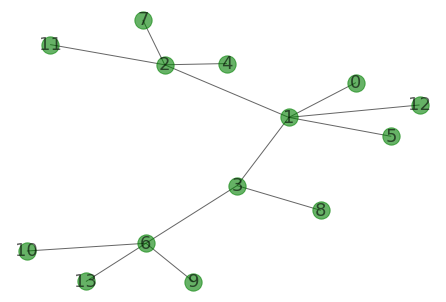

In [12]:
node_labels = dg.nodes()
ld = {}#label dict
for no in dg.nodes():
    ld[no] = ''+str(no)
nx.draw(dg,pos=nx.spring_layout(dg),labels=ld, with_labels = True,font_size=18,node_color='green',alpha=0.6)

### spread

In [13]:
# data in all sample
data = []
for sam in range(SN):
    # data in one sample
    data_sample = []
    # random init
    dg = init_node(dg)
    # spread
    data_sample = spread(dg,step=T)
    data.append(data_sample)

In [14]:
#[sample, step, node]
data = np.array(data) 

In [15]:
data.shape

(128, 4000, 14)

### visulaziation of opinions

In [16]:
xs = []
for i in range(data.shape[1]):
    xs.append(i)
    xs.append(i+1)

In [17]:
def ys_change(ys):
    ys = ys.tolist()
    ys_ = []
    for item in ys:
        ys_.append(item)
        ys_.append(item)
    return ys_

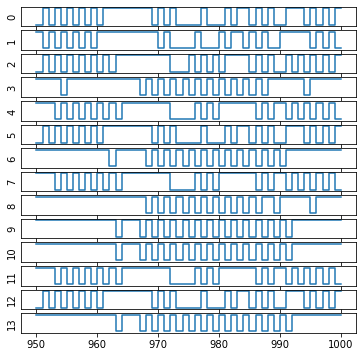

In [18]:
sam = 1
view_n = 14
st = 1900
ed = 2000

plt.figure(figsize=(6,6))
for i in range(view_n):
    ys_ = ys_change(data[sam,:,i])
    plt.subplot(view_n,1,i+1)
    plt.plot(xs[st:ed],ys_[st:ed])
    plt.ylim(-0.1,1.1)
    plt.yticks(())
    plt.ylabel(str(i))
plt.show()

## visualization of 'price'

In [19]:
dp = np.mean(data,axis=2)
price = np.cumsum(dp-0.5,axis=1)

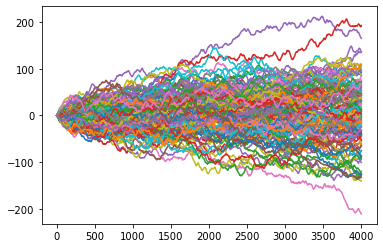

In [20]:
for i in range(dp.shape[0]):
    plt.plot(price[i])
plt.show()

### save the model

In [21]:
ts_name = './dyn_'+Dyn_Type+'_Graph_'+G_type+'_s'+str(SN)+'_n'+str(NN)+'_t'+str(T)+'_ts.npy'
adj_name = './dyn_'+Dyn_Type+'_Graph_'+G_type+'_s'+str(SN)+'_n'+str(NN)+'_t'+str(T)+'_adj.npy'
np.save(ts_name,data)
np.save(adj_name,adj)